# Statistical Analysis

## Importing Dataset and Conversion from .arff

In [1]:
# Website Phishing data from https://archive.ics.uci.edu/dataset/379/website+phishing
path = "PhishingData.arff"

print("Dataset file path:", path)

Dataset file path: PhishingData.arff


In [ ]:
import pandas as pd
from scipy.io import arff

# arff.loadarff necessary for arff file format
data = arff.loadarff(path)

# extracting column names and convert into dataframe
df = pd.DataFrame(data[0])

# decode byte strings to regular strings
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.decode('utf-8')

df.head(15)

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
5,-1,-1,1,-1,-1,1,0,-1,0,1
6,1,-1,0,1,-1,0,0,1,0,-1
7,1,0,1,1,0,0,0,1,1,-1
8,-1,-1,0,-1,-1,-1,-1,1,0,0
9,-1,0,-1,-1,1,1,0,-1,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SFH                1353 non-null   object
 1   popUpWidnow        1353 non-null   object
 2   SSLfinal_State     1353 non-null   object
 3   Request_URL        1353 non-null   object
 4   URL_of_Anchor      1353 non-null   object
 5   web_traffic        1353 non-null   object
 6   URL_Length         1353 non-null   object
 7   age_of_domain      1353 non-null   object
 8   having_IP_Address  1353 non-null   object
 9   Result             1353 non-null   object
dtypes: object(10)
memory usage: 105.8+ KB


## Finding the Strongest Predictor (Correlation)
Evaluating which variable is most strongly correlated with the "phishyness" of a website.

Values closer to 1 (Legitimate) or -1 (Phishy) indicate a strong correlation. For example, based on the results below, a Server Form Handler (`SFH`) marked "Phishy" is a stronger predictor that the Result will be -1 (Phishy) than a `URL` marked "Phishy".

In [4]:
# calculate correlation matrix
correlation_matrix = df.corr()

# get correlations with 'Result' column
result_correlation = correlation_matrix['Result'].sort_values(ascending=False)

# display correlations
print("Correlation with result:")
print(result_correlation)

Correlation with result:
Result               1.000000
web_traffic          0.243896
having_IP_Address   -0.059225
URL_Length          -0.183061
age_of_domain       -0.231931
Request_URL         -0.271609
URL_of_Anchor       -0.287007
popUpWidnow         -0.509749
SSLfinal_State      -0.518762
SFH                 -0.678277
Name: Result, dtype: float64


## Linear Regression
Using linear regression to predict the `Result` based on one single feature. Since `SFH` seems to be the strongest predictor, this code uses it.

Slope: -0.7066872288679771
Intercept: 0.054363109900582865
Regression Equation: y = 0.054363109900582865 + -0.7066872288679771x


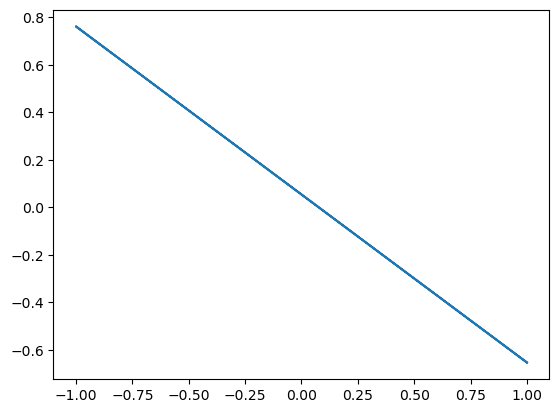

In [5]:
import scipy.stats as stats
import matplotlib.pyplot as plt

for col in df.columns:
    df[col] = pd.to_numeric(df[col])


# define independent (x) and dependent (y) variables
# using SFH
x = df['SFH']
y = df['Result']

linear_reg = stats.linregress(x, y)
slope = linear_reg.slope
intercept = linear_reg.intercept

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"Regression Equation: y = {intercept} + {slope}x")

plt.plot(x, (slope * x + intercept))

## Two Sample T-Test

We want to know if "Legitimate" websites are ***older*** than "Phishy" websites on average. This t-test evaluates the...
- Null Hypothesis (H0​): means are equal.

If the p-value is low (< 0.05), we reject H0​ and conclude that domain age is significant factor distinguishing the Legitimate and Phishy websites.

In [6]:
# filter data for Legitimate and Phishy groups
legit_age = df[df['Result'] == 1]['age_of_domain']
phishy_age = df[df['Result'] == -1]['age_of_domain']

t_stat, p_value = stats.ttest_ind(legit_age, phishy_age, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("P-value is less than 0.05. We REJECT the null hypothesis.")
    print("Conclusion: There IS a significant difference in mean age_of_domain.")
else:
    print("P-value is greater than 0.05. We FAIL to reject the null hypothesis.")
    print("Conclusion: There is NO significant difference in mean age_of_domain.")

T-statistic: -8.747801842841511
P-value: 7.841619377020255e-18
P-value is less than 0.05. We REJECT the null hypothesis.
Conclusion: There IS a significant difference in mean age_of_domain.


## ANOVA

We only have ***three*** categories (Legitimate, Suspicious, and Phishy), a simple T-test (which only compares two) isn't sufficient. As such, we use ANOVA to test if `web_traffic` varies significantly across the three classifications.

If test returns a low p-value, we know that traffic volume is related to the site's classification and NOT due to just random luck.

In [7]:
# filter data into three groups
group_legit = df[df['Result'] == 1]['web_traffic']
group_sus = df[df['Result'] == 0]['web_traffic']
group_phishy = df[df['Result'] == -1]['web_traffic']

# perform one-way ANOVA
f_stat, p_value = stats.f_oneway(group_legit, group_sus, group_phishy)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("P-value is less than 0.05. We REJECT the null hypothesis.")
    print("Conclusion: At least one group HAS a DIFFERENT mean web_traffic.")
else:
    print("P-value is greater than 0.05. We FAIL TO REJECT the null hypothesis.")
    print("Conclusion: Mean web_traffic is NOT significantly different across groups.")

F-statistic: 46.514930985222584
P-value: 2.9137600245169386e-20
P-value is less than 0.05. We REJECT the null hypothesis.
Conclusion: At least one group HAS a DIFFERENT mean web_traffic.
